In [1]:
import numpy as np
import sys, os
import time
import glob
from registration_3d import *
from cartesian import *
from collections import namedtuple
from operator import itemgetter
from pprint import pformat
import matplotlib.pyplot as plt

In [2]:
data_dir = 'DATA/'
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J']
runtype = ['Debug' ,'Debug' ,'Debug' ,'Debug' ,'Debug' ,'Debug' ,'Unknown','Unknown','Unknown']
pa = "PA3"
filename = '/Problem3MeshFile.sur'

In [3]:
def read_mesh( data_dir , filename ):
# get the coordinate of points
# get the vertices of each triangle
    mesh = glob.glob( data_dir + filename )
    mesh_file = open( mesh[0] , "r")
    mesh_lines = mesh_file.read().splitlines()
    mesh_data = []
    
    for num in range(len(mesh_lines)):
        mesh_data.append( mesh_lines[num].split(' ') )
        for i in range(len( mesh_data[-1])):
            mesh_data[-1][i] = mesh_data[-1][i].strip() # to remove space and tabs
    Np = int(mesh_data[0][0])
    mesh_data = mesh_data[1:]
    
    mesh_points = np.asarray(mesh_data[0:Np]).astype(float)
    mesh_data = mesh_data[Np:]
    
    Ntriangles = int(mesh_data[0][0])
    mesh_data = mesh_data[1:]
    mesh_vertices = np.asarray(mesh_data[0:Ntriangles]).astype(int)
    mesh_data = mesh_data[Ntriangles:]
    
    return Np,mesh_points,Ntriangles,mesh_vertices

In [4]:
def read_body( data_dir , filename ):

# get the markers' positions and tip of a body
    body = glob.glob( data_dir + filename )
    body_file = open( body[0] , "r")
    body_lines = body_file.read().splitlines()
    body_data = []
    
    for num in range(len(body_lines)):
        body_data.append( body_lines[num].split() )
        for i in range(len( body_data[-1])):
            body_data[-1][i] = body_data[-1][i].strip() # to remove space and tabs
    Np = int(body_data[0][0])
    body_data = body_data[1:]
    
    body_points = np.asarray(body_data[0:Np]).astype(float)
    body_data = body_data[Np:]
    
    tip = body_data[0]
    tip = np.array(tip).astype(float)
    tip = tip.reshape(1,-1)
    return Np,body_points,tip


In [5]:
def read_sample( data_dir , filename , N_Ap , N_Bp ):
# get the markers' positions and tip of a body
# N_Ap is the number of marker in A
# N_Bp is the number of marker in B
    sample = glob.glob( data_dir + filename )
    sample_file = open( sample[0] , "r")
    sample_lines = sample_file.read().splitlines()
    sample_data = []
    
    for num in range(len(sample_lines)):
        sample_data.append( sample_lines[num].split(',') )
        for i in range(len( sample_data[-1])):
            sample_data[-1][i] = sample_data[-1][i].strip() # to remove space and tabs
    Np = int(sample_data[0][0])
    N_sample = int(sample_data[0][1])
    N_Dp = Np - N_Ap - N_Bp
    sample_data = sample_data[1:]
    sample_data = np.array(sample_data).astype(float)
    A_frames=[]
    B_frames=[]
    
    for i in range(N_sample):
        A_sample_points = np.asarray( sample_data[ i*Np : i*Np + N_Ap ] ).astype( float )
        A_frames.append( A_sample_points )
        
        B_sample_points = np.asarray( sample_data[ i*Np + N_Ap :  i*Np + N_Ap + N_Bp] ).astype( float )
        B_frames.append( B_sample_points )

    A_frames = np.array(A_frames).astype(float)
    B_frames = np.array(B_frames).astype(float)
        
    return A_frames , B_frames

In [6]:
def read_output( data_dir , filename):
# get the markers' positions and tip of a body
# N_Ap is the number of marker in A
# N_Bp is the number of marker in B
    output = glob.glob( data_dir + filename )
    c_data = []
    d_data = []
    dkck = []
    with open( output[0] , "r") as file:
        first_line = next(file)
        # lines = file.readlines()
        
        first_data = next(file)
        first_data = first_data.split()
        # print(first_data)
        first_data = [float(i) for i in first_data]
        c_data = np.array(first_data[0:3]).reshape(1, 3)
        d_data = np.array(first_data[3:6]).reshape(1, 3)
        dkck.append(first_data[6])

        for line in file:
            tmp_line = line.split()
            tmp_line = [float(i) for i in tmp_line]
            c_data = np.concatenate((c_data, np.array(tmp_line[0:3]).reshape(1, 3)))
            d_data = np.concatenate((d_data, np.array(tmp_line[3:6]).reshape(1, 3)))
            dkck.append(tmp_line[6])
    return c_data, d_data, np.array(dkck).reshape(len(dkck), 1)

In [7]:
# output_dir = '/PA3-' + letters[0] + '-' + runtype[0] + '-Output.txt'
# a, b, c = read_output(data_dir, output_dir)

In [8]:
def get_d_k(A_frames, A_points, A_tip, B_frames, B_points, B_tip):
    
    d_k = []
    for i in range(len(A_frames)):
        F_AK = registration_3d(A_points , A_frames[i])
        F_BK = registration_3d(B_points , B_frames[i])
        # F_AK is the transformation from A tool frame to optical frame
        # F_AK is the transformation from B tool frame to optical frame
        d_k_i = points_transform( Fi(F_BK) @ F_AK , A_tip)
        d_k.append(d_k_i)
    d_k = np.array(d_k).astype(float)
    d_k = d_k.reshape(-1,3)
    return d_k

In [9]:
def ProjectOnSegment(c,p,q):
# c is the point we want to find corresponding closest point
# p q are the start and the and of a segment

#according to https://ciis.lcsr.jhu.edu/lib/exe/fetch.php?media=courses:455-655:lectures:finding_point-pairs.pdf
# page 7
    c = np.array(c).astype(float)
    p = np.array(p).astype(float)
    q = np.array(q).astype(float)
    #print(np.dot( c-p , q-p ))
    #print(np.dot( q-p ,q-p ))
    Lambda = np.dot( c-p , q-p ) / np.dot( q-p ,q-p )
    Lambda = max(0, min(Lambda, 1))
    c_star = p + Lambda*(q-p)
    return c_star

In [10]:
def FindClosestPoint( a, p, q, r ):
    
    A = np.zeros((3,2),dtype = float )
    
    for i in range(3):
        A[i][0] = q[i] - p[i]
        A[i][1] = r[i] - p[i]
        
    B = a - p
    B = B.reshape(-1,1)
    X = np.linalg.lstsq(A, B, rcond=None)[0]
    
    Lambda = X[0]
    Miu = X[1]

    a = p + Lambda * (q - p) + Miu * (r - p)
    P_closest = np.zeros(3)

    if Lambda >= 0 and Miu>=0 and Lambda+Miu<=1:
        P_closest = a
    elif Lambda < 0:
        P_closest = ProjectOnSegment(a, r, p)
    elif Miu < 0:
        P_closest = ProjectOnSegment(a, p, q)
    elif Lambda + Miu > 1:
        P_closest = ProjectOnSegment(a, q, r)

    return P_closest


In [11]:
def point_to_triangle(s_k_i , j, mesh_points, mesh_vertices):
    p = mesh_points[mesh_vertices[j][0]] 
    q = mesh_points[mesh_vertices[j][1]]
    r = mesh_points[mesh_vertices[j][2]] 
            
    tmp = FindClosestPoint( s_k_i, p, q, r )
    
    return tmp

In [12]:
def bruteforce_matching(s_k , Np , mesh_points , Ntriangles , mesh_vertices ):
    Ns = s_k.shape[0]
    
    closest_p = []
    for i in range(Ns):
        min_dist = np.finfo(np.float32).max
        P_closest = []
        for j in range(Ntriangles):

            tmp = point_to_triangle(s_k[i] , j, mesh_points, mesh_vertices)

            dist = np.linalg.norm(s_k[i] - tmp)
            if min_dist > dist:
                min_dist = dist
                P_closest = tmp
        closest_p.append(P_closest)
                
    return closest_p

In [13]:
def get_rectangles(Np , mesh_points , Ntriangles , mesh_vertices):
    
    rectangles = np.zeros( (Ntriangles,7) ,dtype=float)
    
    for i in range(Ntriangles):
        p = mesh_points[mesh_vertices[i][0]] 
        q = mesh_points[mesh_vertices[i][1]]
        r = mesh_points[mesh_vertices[i][2]]
        rectangles[i,6] = i
        for j in range(3):
            rectangles[i,j] = min( p[j],q[j],r[j])
        for j in range(3):
            rectangles[i,j+3] = max( p[j],q[j],r[j])
        #print(rectangle[i,0:3] - rectangle[i,3:6])
        
    return rectangles

In [14]:
class KD_tree():
    def __init__(self, Np , mesh_points , Ntriangles , mesh_vertices , rectangles):
        
        self.Np = Np
        self.mesh_points = mesh_points
        self.mesh_vertices = mesh_vertices
        self.Ntriangles =  Ntriangles
        self.rectangles = rectangles
        self.num = np.zeros(Ntriangles+10).astype(int)
        #self.D = mesh_points.shape[1]
        self.D = 3
        
        self.ls = np.zeros( Ntriangles+10 )
        self.rs = np.zeros( Ntriangles+10 )
        
        #self.points = rectangles
        self.Rectangle = np.zeros( (Ntriangles+10,6) )
        
        self.tree = self.build(rectangles.tolist(), 1 , Ntriangles , depth =0 )
        self.nearest_point = []
        self.nearest_dist = 0
        
    def pushup(self, root):
        
        ls = self.ls[root]
        rs = self.rs[root]
        if(ls!=0):
            for i in range(3):
                self.Rectangle[root,i] = min(self.Rectangle[root,i],self.Rectangle[int(ls),i])
                self.Rectangle[root,i+3] = max(self.Rectangle[root,i+3],self.Rectangle[int(ls),i+3]) 
        if(rs!=0):
            for i in range(3):
                self.Rectangle[root,i] = min(self.Rectangle[root,i],self.Rectangle[int(rs),i])
                self.Rectangle[root,i+3] = max(self.Rectangle[root,i+3],self.Rectangle[int(rs),i+3]) 
    
    def point_to_cube(self, start_point, root):
        dis = np.zeros(3)
        for i in range(self.D):
            if(start_point[i] < self.Rectangle[root,i]):
                dis[i] = self.Rectangle[root,i] - start_point[i]
            if(start_point[i] > self.Rectangle[root,i+3]):
                dis[i] = start_point[i] - self.Rectangle[root,i+3]
        dist = np.linalg.norm(dis)
        return dist
    
    def find(self, start_point , left,right,depth):
        if(left>right):
            return np.finfo(np.float32).max
        middle = ((left + right) // 2) 
        
        dist = self.point_to_cube(start_point , middle)
        if(dist > self.nearest_dist):
            return
        
        tmp = point_to_triangle(start_point , self.num[middle], self.mesh_points, self.mesh_vertices)
        dist = np.linalg.norm(start_point - tmp)
        
        if( dist < self.nearest_dist):
            self.nearest_dist = dist
            self.nearest_point = tmp
        
        self.find( start_point , left , middle-1 ,depth)
        self.find( start_point , middle+1 , right,depth)
        
    def FindClosestPoint(self, start_point ):
        
        self.nearest_dist =  np.finfo(np.float32).max
    
        self.find( start_point , 1 , self.Ntriangles , depth=0 ) 
        
        return self.nearest_point
        
    def build( self, points, left,right,depth ):
        if(left>right):
            return 0
        
        axis = depth % self.D

        points.sort(key=itemgetter(axis))
        middle = ((left + right) // 2) 
        #print("points: ",len(points))
        #print("middle: ",middle)
        self.Rectangle[middle] = np.array(points[ middle - left ][0:6]).astype(float)
        self.num[middle] =  points[middle - left ][6]
        
        self.ls[ middle ] = self.build(points[:middle- left] ,left , middle-1 , depth+1 )
        self.rs[ middle ] = self.build(points[middle-left+1:]   ,middle+1, right , depth+1 )
        self.pushup(middle)
        
        return middle

   

In [15]:
def kd_matching(s_k , Np , mesh_points , Ntriangles , mesh_vertices ):
    
    rectangles = get_rectangles(Np , mesh_points , Ntriangles , mesh_vertices)

    kdtree = KD_tree(Np , mesh_points , Ntriangles , mesh_vertices , rectangles)
    
    Ns = s_k.shape[0]
    
    closest_p = []
    for i in range(Ns):
        min_dist = np.finfo(np.float32).max
        tmp = kdtree.FindClosestPoint( s_k[i] )
        closest_p.append(tmp)
    return closest_p

In [16]:
def get_difference( A , B):

    dist = np.zeros(( A.shape[0],1))
    for i in range(A.shape[1]):
        dist[i] = np.linalg.norm( A[i,:] - B[i,:])

    return dist

In [17]:

brute_time_lst = []
kd_time_lst = []
c_avgs = []
d_avgs = []
dkck_avgs = []

c_maxs = []
d_maxs = []
dkck_maxs = []

c_mins = []
d_mins = []
dkck_mins = []

c_ens = []
d_ens = []
dkck_ens = []

c2_avgs = []
c2_maxs = []
c2_mins = []
c2_ens = []

for num in range(9):
    data_type = num
    letter = num
    Np,mesh_points,Ntriangles,mesh_vertices = read_mesh(data_dir , '/Problem3MeshFile.sur')
    N_Ap,A_points,A_tip = read_body(data_dir , '/Problem3-BodyA.txt')
    N_Bp,B_points,B_tip = read_body(data_dir , '/Problem3-BodyB.txt')
    
    sample_dir = '/PA3-' + letters[num] + '-' + runtype[num] + '-SampleReadingsTest.txt'
    A_frames , B_frames = read_sample(data_dir, sample_dir, N_Ap , N_Bp)
    
    d_k = get_d_k(A_frames, A_points, A_tip, B_frames, B_points, B_tip)
    F_reg = np.eye(4)
    #in PA3 F_reg = identity matrix
    s_k = points_transform(F_reg , d_k) 
    
    start = time.time()
    # c_k_i are the closest points on the surface to s_k_i 
    c_k = bruteforce_matching(s_k , Np , mesh_points , Ntriangles , mesh_vertices )
    brute_time = time.time() - start
    brute_time_lst.append(brute_time)
    # print(brute_time)

    start = time.time()
    c_k2 = kd_matching(s_k , Np , mesh_points , Ntriangles , mesh_vertices )
    kd_time = time.time() - start
    # print(kd_time)
    kd_time_lst.append(kd_time)

    c_k = np.array(c_k)
    c_k2 = np.array(c_k2)
    difference = get_difference(d_k,c_k)
    N_samples = len(c_k)
    

    if num < 6:
        output_dir = '/PA3-' + letters[num] + '-' + runtype[num] + '-Output.txt'
        c_output, d_output, dkck = read_output(data_dir, output_dir)
        # print(c_output - c_k)
        # print("\n")
        # print(d_output - d_k)
        # print("\n")
        # print(difference - dkck)
        # print("\n")
        output_dir = '/PA3-' + letters[num] + '-' + runtype[num] + '-Output.txt'
        # difference = get_difference(d_k,c_k)
        c_output, d_output, dkck = read_output(data_dir, output_dir)
        c_diff = np.round(np.abs(c_output - c_k), decimals=2)
        c2_diff = np.round(np.abs(c_output - c_k2), decimals=2)
        d_diff = np.round(np.abs(d_output - d_k), decimals=2)
        dc_diff = np.round(np.abs(difference - dkck), decimals=2)
        # print(c_diff.shape, d_diff.shape, dc_diff.shape)
        c_size = c_diff.shape[0] * c_diff.shape[1]
        # print(dc_diff)
        # print(dc_diff[dc_diff > 1])
        c_eval = [np.round(np.average(c_diff), decimals=2), np.max(c_diff), np.min(c_diff), ((c_diff[c_diff > 1]).shape[0] / c_size)]
        d_eval = [np.round(np.average(d_diff), decimals=2), np.max(d_diff), np.min(d_diff), ((d_diff[d_diff > 1]).shape[0] / c_size)]
        dkck_eval = [np.round(np.average(dc_diff), decimals=2), np.max(dc_diff), np.min(dc_diff), ((dc_diff[dc_diff > 1]).shape[0] / N_samples)]
        c2_eval = [np.round(np.average(c2_diff), decimals=2), np.max(c2_diff), np.min(c2_diff), ((c2_diff[c2_diff > 1]).shape[0] / c_size)]

        c_avgs.append(c_eval[0])
        c_maxs.append(c_eval[1])
        c_mins.append(c_eval[2])
        c_ens.append(c_eval[3])

        c2_avgs.append(c2_eval[0])
        c2_maxs.append(c2_eval[1])
        c2_mins.append(c2_eval[2])
        c2_ens.append(c2_eval[3])
        
        d_avgs.append(d_eval[0])
        d_maxs.append(d_eval[1])
        d_mins.append(d_eval[2])
        d_ens.append(d_eval[3])

        dkck_avgs.append(dkck_eval[0])
        dkck_maxs.append(dkck_eval[1])
        dkck_mins.append(dkck_eval[2])
        dkck_ens.append(dkck_eval[3])
        
    # print(difference)

<function matplotlib.pyplot.show(close=None, block=None)>

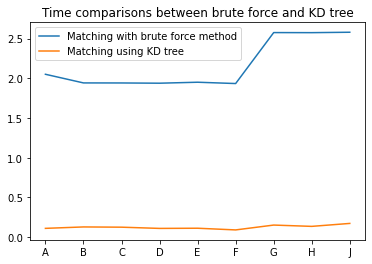

In [18]:
plt.plot(letters, brute_time_lst, label="Matching with brute force method")
plt.plot(letters, kd_time_lst, label="Matching using KD tree")
plt.legend()
plt.title("Time comparisons between brute force and KD tree")
plt.show

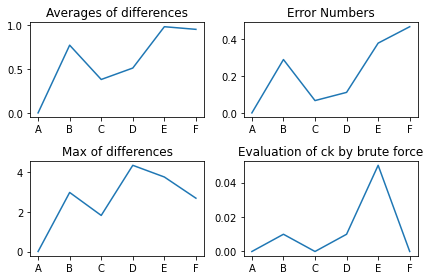

In [19]:
letters = ['A', 'B', 'C', 'D', 'E', 'F']
fig, graph = plt.subplots(2, 2)

graph[0, 0].plot(letters, c_avgs)
graph[0, 0].set_title("Averages of differences")

graph[0, 1].plot(letters, c_ens)
graph[0, 1].set_title("Error Numbers")

graph[1, 0].plot(letters, c_maxs)
graph[1, 0].set_title("Max of differences")

graph[1, 1].plot(letters, c_mins)
graph[1, 1].set_title("Min of differences")

fig.tight_layout()
plt.title("Evaluation of ck by brute force")
plt.show()

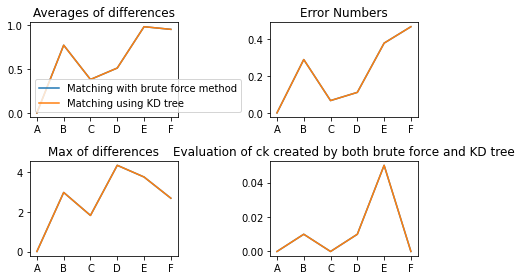

In [20]:
fig, graph = plt.subplots(2, 2)

graph[0, 0].plot(letters, c_avgs, label="Matching with brute force method")
graph[0, 0].plot(letters, c2_avgs, label="Matching using KD tree")
graph[0, 0].legend()
graph[0, 0].set_title("Averages of differences")

graph[0, 1].plot(letters, c_ens, label="Matching with brute force method")
graph[0, 1].plot(letters, c2_ens, label="Matching using KD tree")
# graph[0, 1].legend()
graph[0, 1].set_title("Error Numbers")

graph[1, 0].plot(letters, c_maxs, label="Matching with brute force method")
graph[1, 0].plot(letters, c2_maxs, label="Matching using KD tree")
# graph[1, 0].legend()
graph[1, 0].set_title("Max of differences")

graph[1, 1].plot(letters, c_mins, label="Matching with brute force method")
graph[1, 1].plot(letters, c2_mins, label="Matching using KD tree")
# graph[1, 1].legend()
graph[1, 1].set_title("Min of differences")

fig.tight_layout()
plt.title("Evaluation of ck created by both brute force and KD tree")
plt.show()

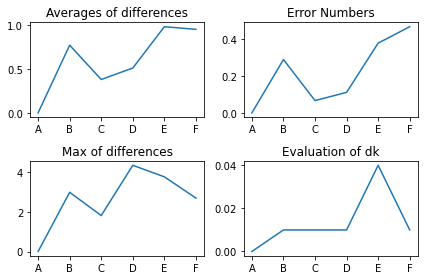

In [21]:

fig, graph = plt.subplots(2, 2)

graph[0, 0].plot(letters, d_avgs)
graph[0, 0].set_title("Averages of differences")

graph[0, 1].plot(letters, d_ens)
graph[0, 1].set_title("Error Numbers")

graph[1, 0].plot(letters, d_maxs)
graph[1, 0].set_title("Max of differences")

graph[1, 1].plot(letters, d_mins)
graph[1, 1].set_title("Min of differences")

fig.tight_layout()
plt.title("Evaluation of dk")
plt.show()

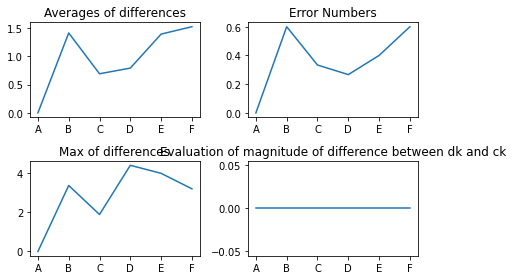

In [22]:
fig, graph = plt.subplots(2, 2)

graph[0, 0].plot(letters, dkck_avgs)
graph[0, 0].set_title("Averages of differences")

graph[0, 1].plot(letters, dkck_ens)
graph[0, 1].set_title("Error Numbers")

graph[1, 0].plot(letters, dkck_maxs)
graph[1, 0].set_title("Max of differences")

graph[1, 1].plot(letters, dkck_mins)
graph[1, 1].set_title("Min of differences")

fig.tight_layout()
plt.title("Evaluation of magnitude of difference between dk and ck")
plt.show()